In [1]:
from __future__ import division
from __future__ import print_function
%matplotlib inline

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from data.multilabel import multilabel_sample_dataframe, multilabel_train_test_split
from features.SparseInteractions import SparseInteractions
from models.metrics import multi_multi_log_loss

# Load Data

In [2]:
path_to_training_data = os.path.join(os.pardir,
                                     'data',
                                     'TrainingSet.csv')

df = pd.read_csv(path_to_training_data, index_col=0)

print(df.shape)

(400277, 25)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [4]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


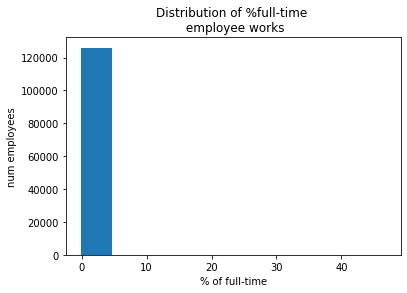

In [22]:
plt.hist(df.FTE.dropna())
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

# Resample Data

In [6]:
LABELS = ['Function',
          'Use',
          'Sharing',
          'Reporting',
          'Student_Type',
          'Position_Type',
          'Object_Type', 
          'Pre_K',
          'Operating_Status']

NON_LABELS = [c for c in df.columns if c not in LABELS]

SAMPLE_SIZE = 40000

sampling = multilabel_sample_dataframe(df,
                                       pd.get_dummies(df[LABELS]),
                                       size=SAMPLE_SIZE,
                                       min_count=25,
                                       seed=43)

dummy_labels = pd.get_dummies(sampling[LABELS])

X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[NON_LABELS],
                                                               dummy_labels,
                                                               0.2,
                                                               min_count=3,
                                                               seed=43)

# Create Preprocessing Tools

In [7]:
NUMERIC_COLUMNS = ['FTE', "Total"]

def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.
        
        :param data_frame: The data as read in with read_csv (no preprocessing necessary)
        :param to_drop (optional): Removes the numeric and label columns by default.
    """
    # drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # joins all of the text items in a row (axis=1)
    # with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [8]:
from sklearn.preprocessing import FunctionTransformer

get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

In [9]:
get_text_data.fit_transform(sampling.head(5))

38     OTHER PURCHASED SERVICES  SCHOOL-WIDE SCHOOL P...
70     Extra Duty Pay/Overtime For Support Personnel ...
198    Supplemental *  Operation and Maintenance of P...
209    REPAIR AND MAINTENANCE SERVICES  PUPIL TRANSPO...
614     GENERAL EDUCATION LOCAL EDUCATIONAL AIDE,70 H...
dtype: object

In [10]:
get_numeric_data.fit_transform(sampling.head(5))

,FTE,Total
38,NaN,653.460000
70,NaN,2153.530000
198,NaN,-8291.860000
209,NaN,618.290000
614,0.71,21747.666875


In [11]:
from sklearn.metrics.scorer import make_scorer

log_loss_scorer = make_scorer(multi_multi_log_loss)

# Train Model Pipeline

In [24]:
from sklearn.feature_selection import chi2, SelectKBest

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MaxAbsScaler

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [25]:
%%time

# set a reasonable number of features before adding interactions
chi_k = 300

# create the pipeline object
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     norm=None, binary=False,
                                                     ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# fit the pipeline to our training data
pl.fit(X_train, y_train.values)

# print the score of our trained pipeline on our test set
print("Logloss score of trained pipeline: ", log_loss_scorer(pl, X_test, y_test.values))

Logloss score of trained pipeline:  3.2756187038396862
CPU times: user 3min 52s, sys: 3.59 s, total: 3min 56s
Wall time: 2min 18s


# Predict Holdout Set and Write Submission

In [26]:
path_to_holdout_data = os.path.join(os.pardir,
                                    'data',
                                    'TestSet.csv')

# Load holdout data
holdout = pd.read_csv(path_to_holdout_data, index_col=0)

# Make predictions
predictions = pl.predict_proba(holdout)

# Format correctly in new DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv called "predictions.csv"
prediction_df.to_csv("predictions.csv")